## 앙상블학습 이어서!

## (3) 부스팅

* 여러 개의 약한 학습기 (weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터나 학습 트리에 ***가중치 부여*** 를 통해 오류를 개선해 나가면서 학습하는 방식
* 대표적 구현 방식으로 AdaBoost, Gradient Boost (GBM) 가 있음

### GBM(Gradient Boosting Machine)

### XGBoost

1. 뛰어난 예측 성능 (:분류와 회귀 영역에서)

2. GBM에 기반하고 있지만, GBM 대비 빠른 수행 시간 (특히 병렬 CPU 환경에서 *병렬 학습이 가능*  해 기존 GBM보다 빠르게 학습을 완료, GPU 지원)

3. 성능 향상 : *overfitting 규제 (Regularization)*  (자체 과적합 규제 기능 있음) & Tree pruning 

4. 기능 : 조기중단, 자체 내장된 교차 검증, 결손값 자체 처리  

#### 조기 중단 기능 : Early Stopping

* 특정 반복 횟수 만큼 더 이상 비용함수가 감소하지 않으면 지정된 반복횟수를 다 완료하지 않고 수행을 종료할 수 있음.
* 학습을 위한 시간을 단축, 특히 최적화 튜닝 단계에서 적절하게 사용 가능
* 너무 반복 횟수를 단축할 경우 예측 성능 최적화가 안된 상태에서 학습이 종료될 수 있으므로 유의 

### Python Native XGBoost

* xgboost.train()
* xgboost.predict()

In [1]:
import xgboost
print(xgboost.__version__)
from xgboost import plot_importance  # feature importance plot해주는 module

1.7.3


In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [4]:
# 8:2 train, test data split
X = cancer_df.iloc[:,:-1]
y = cancer_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

# split train data 9:1 for validation data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_tr.shape[0], X_val.shape[0], X_test.shape[0]) # train data 406, validation data 46, test data 114

409 46 114


In [7]:
# XGBoost는 사이킷런과 다르게 전용 데이터 객체인 DMatrix를 사용
# 데이터 프레임들을 모두 DMatrix로 생성하여 모델에 입력해줘야 함. 
# DMatrix는 numpy array, DataFrame에서도 변환 가능

dtr = xgboost.DMatrix(data = X_tr, label = y_tr)
dval = xgboost.DMatrix(data = X_val, label = y_val)
dtest = xgboost.DMatrix(data = X_test, label = y_test)

In [8]:
# xgboost 이용해 학습을 수행하기 전에 먼저 하이퍼 파라미터 설정 : 주로 딕셔너리 형태로 입력함. 

params = { 'max_depth':3, # 트리 최대 깊이
           'eta':0.05,    # 학습률 (scikit-learn에서 'learning-rate ')
           'objective':'binary:logistic',  # 목적함수
           'eval_metric':'logloss'  # 오류 함수의 평가 성능 지표
         }
num_rounds = 400  # 부스팅 반복 횟수

# 학습 데이터 셋은 'train', 평가 데이터 셋은 'eval'로 명기하는 개별 튜플을 가지는 list type로 설정

eval_list = [(dtr, 'train'), (dval, 'eval')]

In [9]:
# xgboost 모듈의 train()함수를 호출하여 학습 진행
# 주어진 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달

xgb_model = xgboost.train(params = params,            # 파라미터
                          dtrain=dtr,                 # 학습용 데이터의 dmatrix
                          num_boost_round=num_rounds, # 부스팅(학습) 반복 횟수
                          early_stopping_rounds=50,   # 조기 반복 중지
                          evals=eval_list)            # 평가 리스트

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

[170]	train-logloss:0.01312	eval-logloss:0.26133
[171]	train-logloss:0.01304	eval-logloss:0.26148
[172]	train-logloss:0.01297	eval-logloss:0.26157
[173]	train-logloss:0.01285	eval-logloss:0.26253
[174]	train-logloss:0.01278	eval-logloss:0.26229
[175]	train-logloss:0.01267	eval-logloss:0.26086
[176]	train-logloss:0.01258	eval-logloss:0.26103


eval_logloss로 표시되는 검증 데이터에 대한 logloss값이 [126]번에서 가장 낮고, 그 이후로 50번의 반복동안 더 작아지지 않았기 때문에 더 이상 반복하지 않고 [176]번째에서 멈춘 것. 

In [10]:
# 예측을 위해서는 predict() method
pred_probability = xgb_model.predict(dtest)
print(np.round(pred_probability[:10],3))

# p>0.5 return 1, p<0.5 return 0 (since this is classification)
preds = [1 if x>0.5 else 0 for x in pred_probability]
print(preds[:10])

[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

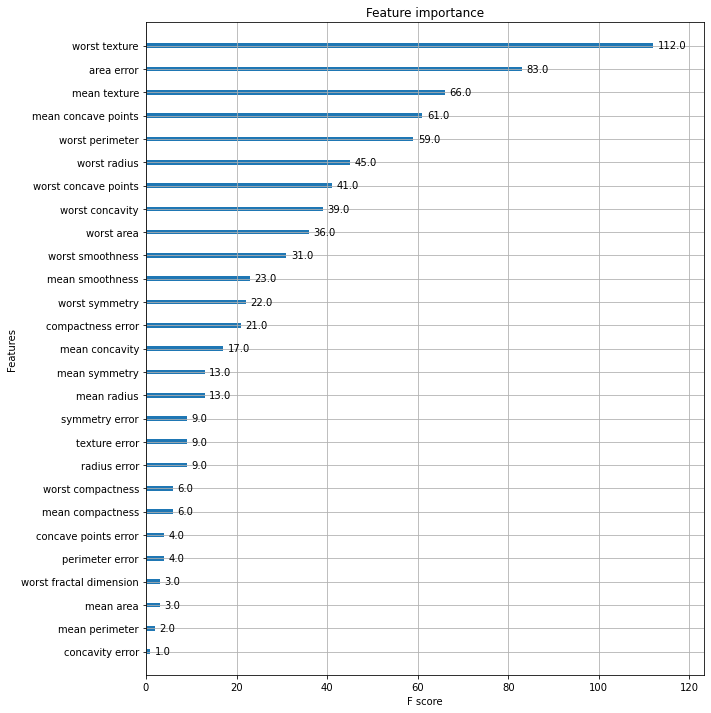

In [11]:
# Feature importance API
# 기준은 F score 기반 : 해당 피처가 트리 분할 시 얼마나 자주 사용되었는지를 지표로 나타낸 값

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

아까 DMatrix 생성할 때, **dataframe**에서 가져왔기 때문에 feaure_names들이 알아서 y축에 표기된 그림이 만들어짐!

In [12]:
# XGBoost evaluation 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print('오차 행렬 ', confusion_matrix(y_test, preds))
print('정확도', accuracy_score(y_test, preds))
print('정밀도', precision_score(y_test,preds))
print('재현율', recall_score(y_test, preds))
print('f1 score: ', f1_score(y_test, preds))
print('AUC : ', roc_auc_score(y_test, pred_probability))

오차 행렬  [[34  3]
 [ 2 75]]
정확도 0.956140350877193
정밀도 0.9615384615384616
재현율 0.974025974025974
f1 score:  0.967741935483871
AUC :  0.9936819936819937


In [13]:
# cv API : 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터를 구할 수 있는 방법 제공
xgboost.cv(params = params, 
           dtrain = dtr,
           num_boost_round = 400,
           nfold = 3,
           stratified = False,
           metrics = 'logloss',
           early_stopping_rounds = 50)

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.650091,0.000594,0.654366,0.001346
1,0.610961,0.001155,0.619510,0.002574
2,0.574897,0.001243,0.586678,0.002409
3,0.541746,0.001367,0.556695,0.002249
4,0.511562,0.001747,0.530457,0.003369
...,...,...,...,...
225,0.011081,0.001109,0.103566,0.011053
226,0.011056,0.001110,0.103499,0.011116
227,0.011031,0.001111,0.103633,0.011044
228,0.011006,0.001112,0.103557,0.010986


### Scikit-learn Wrapper XGBoost

In [19]:
from xgboost import XGBClassifier 

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05,max_depth=3,eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [15]:
print('오차 행렬 ', confusion_matrix(y_test, w_preds))
print('정확도', accuracy_score(y_test, w_preds))
print('정밀도', precision_score(y_test,w_preds))
print('재현율', recall_score(y_test, w_preds))
print('f1 score: ', f1_score(y_test, w_preds))
print('AUC : ', roc_auc_score(y_test, w_pred_proba))

오차 행렬  [[34  3]
 [ 1 76]]
정확도 0.9649122807017544
정밀도 0.9620253164556962
재현율 0.987012987012987
f1 score:  0.9743589743589742
AUC :  0.9954369954369954


In [20]:
# scikit-learn wrapper XGBoost에서 조기 중단 수행

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)

evals = [(X_tr, y_tr), (X_val, y_val)] # 성능평가를 수행할 데이터 세트 

xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss",
               eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

[130]	validation_0-logloss:0.01886	validation_1-logloss:0.25712
[131]	validation_0-logloss:0.01863	validation_1-logloss:0.25609
[132]	validation_0-logloss:0.01839	validation_1-logloss:0.25649
[133]	validation_0-logloss:0.01816	validation_1-logloss:0.25789
[134]	validation_0-logloss:0.01802	validation_1-logloss:0.25811
[135]	validation_0-logloss:0.01785	validation_1-logloss:0.25794
[136]	validation_0-logloss:0.01763	validation_1-logloss:0.25876
[137]	validation_0-logloss:0.01748	validation_1-logloss:0.25884
[138]	validation_0-logloss:0.01732	validation_1-logloss:0.25867
[139]	validation_0-logloss:0.01719	validation_1-logloss:0.25876
[140]	validation_0-logloss:0.01696	validation_1-logloss:0.25987
[141]	validation_0-logloss:0.01681	validation_1-logloss:0.25960
[142]	validation_0-logloss:0.01669	validation_1-logloss:0.25982
[143]	validation_0-logloss:0.01656	validation_1-logloss:0.25992
[144]	validation_0-logloss:0.01638	validation_1-logloss:0.26035
[145]	validation_0-logloss:0.01623	valid

In [22]:
print('오차 행렬 ', confusion_matrix(y_test, ws50_preds))
print('정확도', accuracy_score(y_test, ws50_preds))
print('정밀도', precision_score(y_test,ws50_preds))
print('재현율', recall_score(y_test, ws50_preds))
print('f1 score: ', f1_score(y_test, ws50_preds))
print('AUC : ', roc_auc_score(y_test, ws50_pred_proba))

오차 행렬  [[34  3]
 [ 2 75]]
정확도 0.956140350877193
정밀도 0.9615384615384616
재현율 0.974025974025974
f1 score:  0.967741935483871
AUC :  0.9933309933309933


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

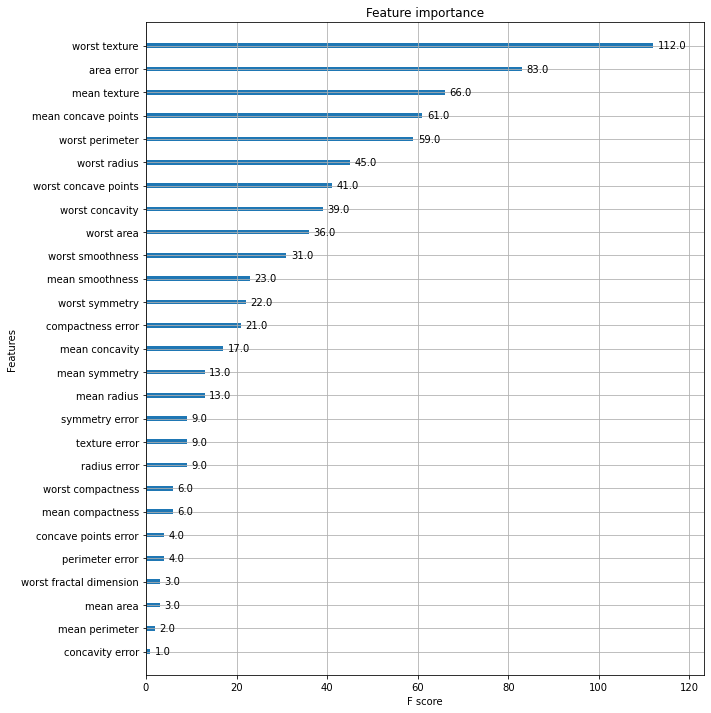

In [23]:
# feature importance plot
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper, ax=ax)

### LightGBM

#### XGBoost 대비 장점
* 더 빠른 학습과 예측 수행 시간
* 더 적은 메모리 사용량
* 카테고리형 feature의 자동 변환과 최적 분할 (원-핫 인코딩 등을 사용하지 않고도 카테고리형 feature를 최적으로 변환하고 이에 따른 노드 분할을 수행)

#### LightGBM 트리 분할 방식 : Leaf Wise
* Level Wise (균형 트리 분할) // Leaf Wise (리프 중심 트리 분할)
* 최대 손실 값을 가지는 leaf node를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적 트리가 생성됨
* 그럼에도 불구하고 이렇게 최대 손실값을 가지는 리프 노드를 지속적으로 분할해 생성된 규칙 트리는 학습을 반복할수록 결국 균형 트리 분할 방식보다 예측 오류 손실을 최소화할 수 있다는 것이 LightGBM의 구현사상. 

In [5]:
data = load_breast_cancer()
cancer_df = pd.DataFrame(data = data.data, columns = data.feature_names)
cancer_df['target'] = data.target
X = cancer_df.iloc[:,:-1]
y = cancer_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0)

In [11]:
from lightgbm import LGBMClassifier

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate = 0.05)

# 조기 중단 수행 가능
evals = [(X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set = evals, verbose = True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.628152
[2]	valid_0's binary_logloss: 0.588562
[3]	valid_0's binary_logloss: 0.552682
[4]	valid_0's binary_logloss: 0.521119
[5]	valid_0's binary_logloss: 0.491516
[6]	valid_0's binary_logloss: 0.465883
[7]	valid_0's binary_logloss: 0.441729
[8]	valid_0's binary_logloss: 0.420045
[9]	valid_0's binary_logloss: 0.400342
[10]	valid_0's binary_logloss: 0.381977
[11]	valid_0's binary_logloss: 0.364589
[12]	valid_0's binary_logloss: 0.348948
[13]	valid_0's binary_logloss: 0.333891
[14]	valid_0's binary_logloss: 0.319559
[15]	valid_0's binary_logloss: 0.305596
[16]	valid_0's binary_logloss: 0.292676
[17]	valid_0's binary_logloss: 0.280226
[18]	valid_0's binary_logloss: 0.269133
[19]	valid_0's binary_logloss: 0.25658
[20]	valid_0's binary_logloss: 0.247111
[21]	valid_0's binary_logloss: 0.235361
[22]	valid_0's binary_logloss: 0.22861
[23]	valid_0's binary_logloss: 0.219427
[24]	valid_0's binary_logloss: 0.211947
[25]	valid_0's binary_logloss: 0.203909
[26]	valid_

[287]	valid_0's binary_logloss: 0.00105208
[288]	valid_0's binary_logloss: 0.00103364
[289]	valid_0's binary_logloss: 0.00102044
[290]	valid_0's binary_logloss: 0.000972522
[291]	valid_0's binary_logloss: 0.00100638
[292]	valid_0's binary_logloss: 0.000994361
[293]	valid_0's binary_logloss: 0.000948112
[294]	valid_0's binary_logloss: 0.000940454
[295]	valid_0's binary_logloss: 0.000913094
[296]	valid_0's binary_logloss: 0.000945899
[297]	valid_0's binary_logloss: 0.000901407
[298]	valid_0's binary_logloss: 0.000887764
[299]	valid_0's binary_logloss: 0.000920522
[300]	valid_0's binary_logloss: 0.000921427
[301]	valid_0's binary_logloss: 0.000960649
[302]	valid_0's binary_logloss: 0.000997216
[303]	valid_0's binary_logloss: 0.000967617
[304]	valid_0's binary_logloss: 0.00100585
[305]	valid_0's binary_logloss: 0.000987171
[306]	valid_0's binary_logloss: 0.000940958
[307]	valid_0's binary_logloss: 0.000936805
[308]	valid_0's binary_logloss: 0.000977959
[309]	valid_0's binary_logloss: 0.000

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [12]:
print('Confusion Matrix')
print(confusion_matrix(y_test, preds))
print('accuracy score: ', accuracy_score(y_test, preds))
print('precision score: ', precision_score(y_test, preds))
print('recall score: ', recall_score(y_test, preds))
print('f1 score: ', f1_score(y_test, preds))
print('AUC: ', roc_auc_score(y_test, pred_proba))

Confusion Matrix
[[46  1]
 [ 1 66]]
accuracy score:  0.9824561403508771
precision score:  0.9850746268656716
recall score:  0.9850746268656716
f1 score:  0.9850746268656716
AUC:  0.9980946332168943


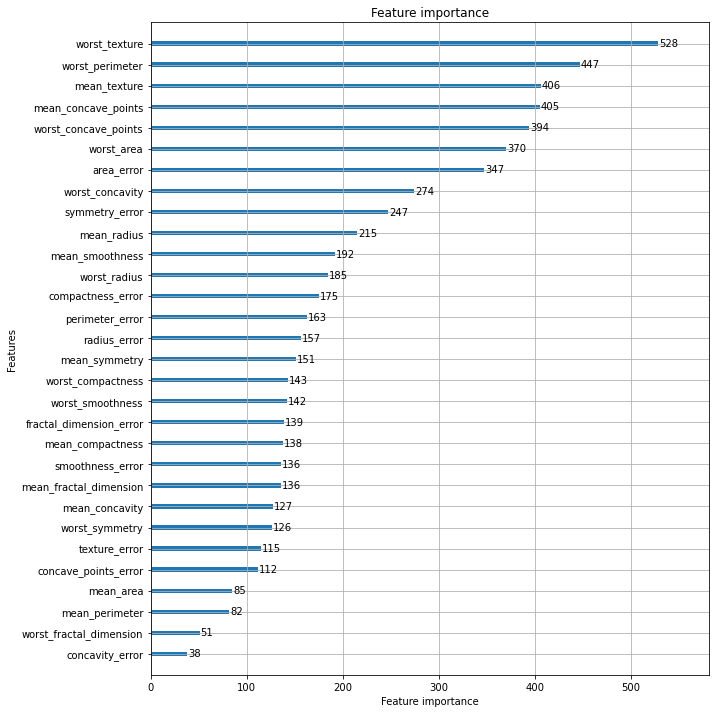

In [15]:
# feature importance 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize= (10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.show()